In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from xgboost import XGBRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
# 1. Data reading and merging
kc_data = pd.read_csv('data/kc_house_data.csv')
desc_data = pd.read_csv('data/description.csv')
desc_data.rename(columns={'House_ID': 'id', 'Description': 'description'}, inplace=True)
data = pd.merge(kc_data, desc_data[['id', 'description']], on='id', how='left')
data['date'] = pd.to_datetime(data['date'], format='%Y%m%dT%H%M%S')

# 2. Feature engineering
numeric_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long']
categorical_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_struct = preprocessor.fit_transform(data)

tfidf = TfidfVectorizer(max_features=200)
X_text = tfidf.fit_transform(data['description'].fillna(''))

X = hstack([X_struct, X_text])
y = data['price']

In [4]:
# 3. Model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 162137.94986265717
MAE: 151258.19270833334
R²: 0.17224898023096447


In [5]:
#4. Causal inference - age and price
data['age'] = 2025 - data['yr_built']
data['policy_treated'] = (data['age'] >= 50).astype(int)

X_causal = sm.add_constant(data['age'])
y_causal = data['price']

model_causal = sm.OLS(y_causal, X_causal).fit()
print(model_causal.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.1102
Date:                Wed, 05 Mar 2025   Prob (F-statistic):              0.742
Time:                        10:51:19   Log-Likelihood:                -426.54
No. Observations:                  30   AIC:                             857.1
Df Residuals:                      28   BIC:                             859.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.477e+05   1.64e+05      3.337      0.0

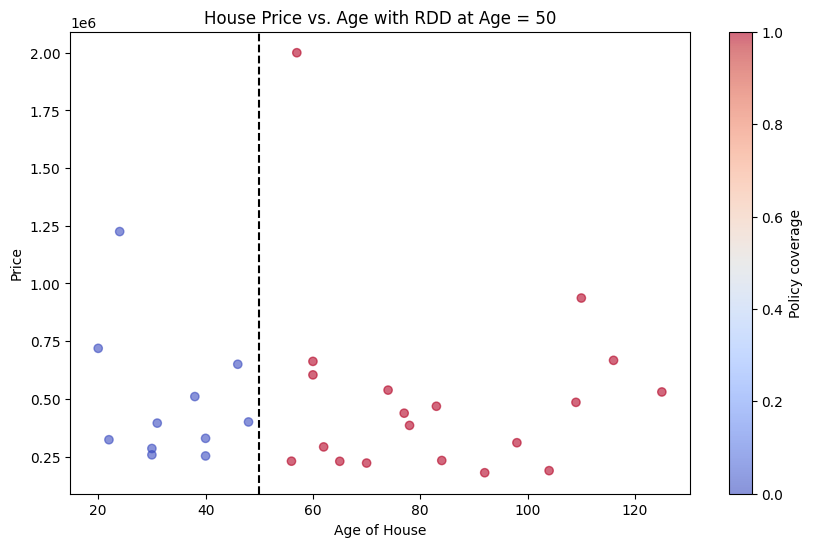

In [6]:
#5. Visualization
plt.figure(figsize=(10, 6))
plt.scatter(data['age'], data['price'], c=data['policy_treated'], cmap='coolwarm', alpha=0.6)
plt.axvline(50, color='k', linestyle='--')
plt.title('House Price vs. Age with RDD at Age = 50')
plt.xlabel('Age of House')
plt.ylabel('Price')
plt.colorbar(label='Policy coverage')
plt.savefig('age_vs_price.png')
plt.show()